# Neural Networks :  Problem 1
## Prediction by Forward Propogation

## Disclaimer
These exercises are based on the Stanford Machine Learning Course [CS229](http://cs229.stanford.edu) of Andrew Ng. The environment of the exercise have been tuned to the theory content taught at Ravensburg Weingarten University.

We are using the Python programming language. If you don't know Python or if you would like to refresh your memory, take a look at the [Python tutorial](http://docs.python.org/tut/).
We will mostly work with NumPy, the fundamental package for scientific computing in Python. Please read the [NumPy quickstart tutorial](https://numpy.org/devdocs/user/quickstart.html). In addition, the documention of MatPlotLib and Scipy lib can be found here: .[MatplotLib](https://matplotlib.org/). [Scipy](https://docs.scipy.org/doc/scipy/reference/tutorial/).

In this problem, we work the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset and we will use Neural Network to recognize hand-written digits.(from 0 to 9). Automatic digit recognition is in wide practice in the area of Banking, Postal Services and more. With this excercise the user will learn to implement the learned theory to classifiy such inputs.

In [1]:

# Used for manipulating directory paths
import os

# Scientific and vector computation for python
import numpy as np

# Plotting library
from matplotlib import pyplot

# Optimization module in scipy
from scipy import optimize

# will be used to load MATLAB mat datafile format
from scipy.io import loadmat

# for plotting grayscale
from PIL import Image

### Dataset : 
The dataset contains 5000 training examples of handwritten digits (This is a subset of the MNIST handwritten digit dataset). As the baseline of this problem is mention before, the data set has been saved in a native Octave/MATLAB matrix format. We use the .mat format here because this is the exact same dataset provided in the MATLAB version of mentioned source assignments. The good news is that Python provides mechanism to load the dataset in given format using the **scipy.io** module. This function returns a python dictionary with keys containing the variable names within the .mat file. The dataset can be downloaded from : 

Simply use the below snippet of code to extract the data.

In [2]:
#  training data stored in arrays X, y
data = loadmat('./ex3data1.mat')

X, y = data['X'], data['y'].ravel()
m = y.size

print('Total size of dataset is {} images'.format(y.size))

Total size of dataset is 5000 images


There are 5000 training examples in the given dataset. Each training example is a 20 pixel by 20 pixel grayscale image. Each pixel is represented by a floating point number indicating the grayscale intensity of the pixel. The 20 by 20 grid of pixels is “flattened” into a 400-dimensional vector. As a result, each of the training examples becomes a single row in our data matrix **X**. This gives us size 5000 by 400 matrix X.

$$ X = \begin{bmatrix} - \: (x^{(1)})^T \: - \\ -\: (x^{(2)})^T \:- \\ \vdots \\ - \: (x^{(m)})^T \:-  \end{bmatrix} $$

The second part of the training set is a 5000-dimensional vector y that contains labels for the training set

**Here's a small modification to be done**. Since the original dataset was in .mat format and MATLAB doesn't have 0 indexing, the digit zero is mapped to ouput (y) = 10. Before moving further, we have to map the digit zero to output (y) = 0.

In [3]:
# Setting the zero digit to 0.
# This is an artifact due to the fact that this dataset was used in...
# ...MATLAB where there is no index 0
y[y == 10] = 0

### 1.A Visualize Dataset

Let us begin by visualizing a subset of the training set. We plot take a random integer out of the total size of our dataset i.e. 5000 images. This index is passed to the **show_img** function to produce a grayscale image. The function works as follows: First it extract the whole row with the specified index from the X matrix. This need to be put in original shape to display correctly. Lets call this process as 'unflattening'. Here the row vector is reshaped to its original shape 20 by 20. This is done by Numpy **reshape** command. Here we use the Fortran indexing order to stack the row elements as per correct order. (Otherwise you see an incorrect image). Further, out input vector is in form of floating point numbers ranging from 0 to 1. For plotting Grayscale Image these need to be scaled to a factor of 0 to 255. 

Use the PIL library to plot the image. [PIL](https://pillow.readthedocs.io/en/stable/reference/Image.html)
The image is rescaled to get better visualization.

Size of below image is : (512, 512)


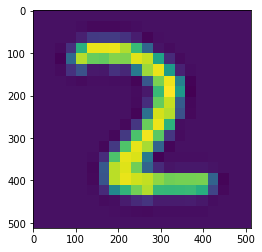

In [4]:
# Choose a random index
rand_indices = np.random.choice(m, 1)

def show_img(a):

    # Select the row from X matrix with the specified argument
    selc = X[a, :]

    # Unflatten the row to original 20x20 size
    selc = np.reshape(selc, (20,20), order='F')
    
    # Multiply by 255 to get a grayscale range in 0 to 255
    im = Image.fromarray(selc*255)

    # Increase the size for better visualization
    size = (512,512)
    im = im.resize(size)
    pyplot.imshow(im)
    print('Size of below image is : {}'.format(size))


show_img(rand_indices)

### 1.B Model Representation and Feedforward Prediction

You will be using a Neural Network that has already been trained. Again, the weights have been taken from the source problem of Stanford Uni. Your goal is to implement the feedforward propagation algorithm to use our weights for prediction.

Out understanding of Neural Network is shown in the following figure.
<img src='./graphic/sample.png' width='350' height='350'>

It has 3 layers: Input layer, Hidden layer and Output layer. Note that our inputs **X** are pixel values of digit images. Since the images are of size 20×20, this gives us 400 Input layer units. 

You are provided with a set of network parameters ($\Theta^{(1)}$, $\Theta^{(2)}$) already trained by Standford Uni. They are stored in `ex3weights.mat`. Let us load those parameters into variables `Theta1` and `Theta2`. The parameters have dimensions that are sized for a neural network with 25 units in the second layer and 10 output units (corresponding to the 10 digit classes). Note that each of the two weight matrix have one column extra.

**Why ?** Remember Bias terms !

In [5]:
# Setup the parameters you will use for this exercise
input_layer_size  = 400  # 20x20 Input Images of Digits
hidden_layer_size = 25   # 25 hidden units
num_labels = 10          # 10 labels, from 0 to 9

# Load the .mat file, which returns a dictionary 
weights = loadmat('./ex3weights.mat')

# get the model weights from the dictionary
# Theta1 has size 25 x 401
# Theta2 has size 10 x 26
Theta1, Theta2 = weights['Theta1'], weights['Theta2']

print('Size of Weight-Vector for Hidden Layer is: {} '.format(Theta1.shape))
print('Size of Weight-Vector for Output Layer is: {} '.format(Theta2.shape))

Size of Weight-Vector for Hidden Layer is: (25, 401) 
Size of Weight-Vector for Output Layer is: (10, 26) 


Now we will implement feedforward propagation for the neural network. We will implement the feedforward computation that computes $h_\theta(x^{(i)})$ for every example $i$ and returns the associated predictions. The prediction from the neural network will be the label that has the largest output $\left( h_\theta(x) \right)_k$.

**What do we do to calculate $h_\theta(x^{(i)})$ ?**

We apply a non-linear function after linear transformation. That means:

$$
h(x) = f(dot.product(W,x))
$$

where b is the Bias term.
We have earlier seen the dimensions of our pre-given weight matrices. Note that the bias term is already included in it. We have two options: (1) We can increment the input vector X by a row of 1s or (2) We can split the computation as shown in the equation below.

$$
h(x) = f(Wx + b)
$$

We resort to the second option for this problem. Since we have a two layer Neural network, we have to apply this $h$ function twice. 

$$
h_\theta(x) = f_2(W_2f_1(W_1x + b_1) + b_2)
$$

**What is f function ?**
For Neural Networks, there are many activations function f, as you can see in the picture shown below. But out of these a famous one is the Sigmoid Function. We use this one for our problem here. The sigmoid function computes the probabibility of each class and we can choose the output class with the max value of computed probabilities.
<img src='./graphic/2.png' width='550' height='550'>

In [6]:
# Swap first and last columns of Theta2, due to legacy from MATLAB indexing, 
# Since the weight file ex3weights.mat was saved based on MATLAB indexing
Theta2 = np.roll(Theta2, 1, axis=0)

def sigmoid(z):
    
    # Computes the sigmoid of z.
    
    return 1.0 / (1.0 + np.exp(-z))

def predict(t1,t2,X):
    # The prediction function computes the probability of every label as described in theory
    # Find the index of the max value to give its class.
    
    # f1 function
    z2 = np.dot(Theta1[:,1:],np.transpose(X).flatten())+ Theta1[:,0]
    a2 = sigmoid(z2)

    # f2 function
    z1 = np.dot(Theta2[:,1:],a2)+ Theta2[:,0]
    a1 = sigmoid(z1)
    
    return np.argmax(a1), a1[np.argmax(a1)]

# Predict a class of a random index
klass, probability = predict(Theta1, Theta2, X[rand_indices,:])
print('The predicted class of the given output is {} with probability = {}'.format(klass, probability))
print('The true class of the given output wrt dataset is {}.'.format(y[rand_indices]))

The predicted class of the given output is 2 with probability = 0.936764085863
The true class of the given output wrt dataset is [2].


### 1.C Predicting Accuracy of the trained model

To test the accuracy of out predictive model, we can one by one predict all the training inputs and then compare the predicted output with the actual output.

$$
Accuracy = 100 - \frac{err*100}{Total}
$$

where err = Count of inputs that are falsely classiifed by predictor model

Total = Total number of tested inputs

In [7]:
err = 0.0 # Initiating variable

# Predict for every
for k in range(m):
    klass_pred, pred = predict(Theta1, Theta2, X[k,:])
    klass_act = y[k]
    
    # if incorrect prediction, then count as inaccuracy
    if klass_pred != klass_act:
        err = err + 1.0
        
print('Total errors in prediction with give model are : {}'.format(err))
print('Accuracy of trained model is {}%'.format((1-err/m)*100))

Total errors in prediction with give model are : 124.0
Accuracy of trained model is 97.52%
